<a href="https://colab.research.google.com/github/rmadhira86/w251-finalproject/blob/joe/Computer-Vision/Loading-Custom-Dataset/loading_custom_dataset_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction

Pytorch has a great ecosystem to load custom datasets for training machine learning models. This is the first part of the two-part series on loading Custom Datasets in Pytorch. In this walkthrough, we’ll learn how to load a custom image dataset for classification.

We’ll be using the landmark dataset available [here](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip). It is a subset of the Google Landmark Data v2. It has 50 classes and contains various landmarks from around the globe.

For this exercise, we’ll keep the following folder structure:

![folder_structure](https://github.com/UtkarshGarg-UG/Deep-Learning-Projects/blob/main/Computer-Vision/Loading-Custom-Dataset/folder_structure.png?raw=1)

This is a straightforward folder structure with a root folder as the Train/Test folders containing classes with images inside them. As we’ll see, it doesn’t matter in what structure we get the data in. The data can all be in a single folder with class names in the image names (like “Cat_001.jpg”) or even in a CSV, we can process all this in our custom dataset class.

Furthermore, we’ll be using [Albumentations](https://github.com/albumentations-team/albumentations) library for image augmentation. This library contains a huge number of available options for image augmentations. So, we’ll be learning about how to use it in our custom dataset pipeline. You can install it using :

> pip install -U albumentations

![parrots](https://github.com/UtkarshGarg-UG/Deep-Learning-Projects/blob/main/Computer-Vision/Loading-Custom-Dataset/parrots.png?raw=1)


In [1]:
!pip list


Package                       Version
----------------------------- ---------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.4.6
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.4.2
bs4                           0.0.1
CacheCo

## 2. Import libraries

In [2]:
!sudo apt-get --purge remove opencv-python-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package opencv-python-headless


In [3]:
!pip install opencv-python-headless==4.1.2.30


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

### 3. Define Params

In [5]:
####################################################
#                Define parameters
####################################################

params = {
#    "model": "resnet50",
    #"device": "cuda",
#    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "n_epochs": 10,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 5
}



### 4. Define Transform

Next, we define our augmentations using Albumentations. We define different augmentations for train and test. We apply transformations related to crop/rotation, colour/saturation, and brightness on training data. We also normalise both train and test data with image net mean and std deviation. Finally, we convert the data to PyTorch tensor using ToTensor().

In [6]:
#######################################################
#               Define Transforms
#######################################################


train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=params["image_size"], width=params["image_size"]),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=params["image_size"], width=params["image_size"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

### 5. Create Train, Valid, and Test sets

Next, we create the Train, Valid, and Test sets. Here we create separate lists of image paths for Train, Valid, and Test sets. These will be used in our Dataset class which will be defined for a custom dataset.


In [7]:
train_data_path = 'images/train'
test_data_path = 'images/test'

In [14]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'images/train' 
test_data_path = 'images/test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])


#split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 


test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("\nTrain size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  images/train/Class 1/14.png
class example:  Class 1

Train size: 13
Valid size: 4
Test size: 8


### 6. Create index_to_class and class_to_index dictionaries
We can’t use the class names directly for models. We create mappings of classes to index and index to classes.

In [15]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}


In [16]:
idx_to_class

{0: 'Class 1'}

In [17]:
print('Length of train: ', len(train_image_paths))
print('Length of test: ', len(test_image_paths))

Length of train:  13
Length of test:  8


### 7. Create Dataset Class

This is the core of our custom dataset. The structure of the dataset class is something like this:

![dataset_class](https://github.com/UtkarshGarg-UG/Deep-Learning-Projects/blob/main/Computer-Vision/Loading-Custom-Dataset/dataset_class.png?raw=1)

We create our LandmarkDataset class by inheriting the Dataset class:

> from torch.utils.data import Dataset

First, we define the __init__ function. As soon as we create an instance of our LandMarkDataset class, this function is called by default. This function should contain all operations that we want to run on the whole dataset (eg. train) once. The usage of this will be more clear in the next part of this series where we create a custom machine translation dataset. For now, we define the variables for image_paths and transforms for the corresponding Train, Valid, and Test sets.

Then we have the __len__ function which just returns the length of the dataset. This is used afterward by the DataLoader to create batches.

And finally, we have __getitem__. This processes and returns 1 datapoint at a time.

In [21]:
#######################################################
#               Define Dataset Class
#######################################################

class COVIDDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [22]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = COVIDDataset(train_image_paths,train_transforms)
valid_dataset = COVIDDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = COVIDDataset(test_image_paths,test_transforms)



In [24]:
print('The shape of tensor for 10th image in train dataset: ',train_dataset[9][0].shape)
print('The label for 10th image in train dataset: ',train_dataset[9][1])

The shape of tensor for 10th image in train dataset:  torch.Size([3, 256, 256])
The label for 10th image in train dataset:  0


Let’s visualize some images after augmentation through the train_dataset.

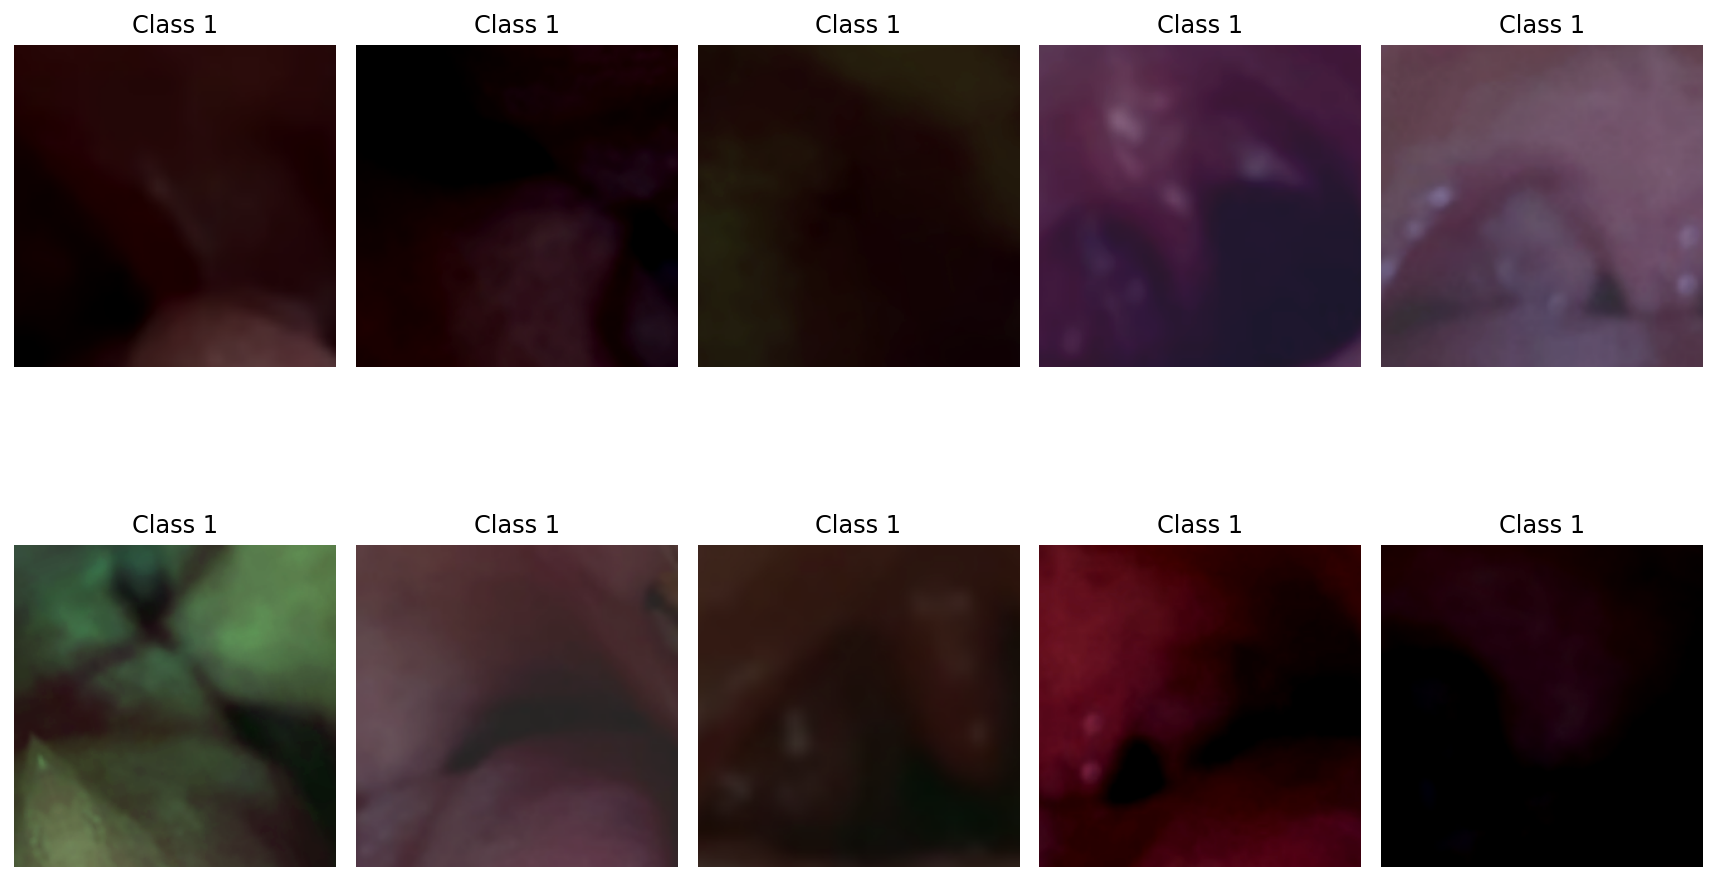

In [25]:
#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

### 8. Creating the DataLoader
The final step. DataLoader class is used to load data in batches for the model. This helps us processing data in mini-batches that can fit within our GPU’s RAM. First, we import the DataLoader:
> from torch.utils.data import DataLoader

Initiating the dataloader by sending in an object of the dataset and the batch size.

In [26]:
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=params["batch_size"], shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False
)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Once we have the dataloader instance — train_loader, we can use an iterator to access the data like this:

In [27]:
next(iter(train_loader))[1].shape

torch.Size([13])

This is what we use to batch out the data in our training loop. Every time we run the iterator, the dataloader selects the next 64 indexes and runs it through the __getitem__ in dataset class one by one and then returns it to the training loop.

Now the data is ready to be used in a classification model!